In [26]:
from sympy import *
from IPython.display import display, Math
import numpy as np
init_printing(use_unicode=True)
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [21]:
from sympy import solve

x, y, sigma, mu, delta, alpha, beta, ro, eta, b, lambd = symbols(
    'x y σ μ δ α β ρ η b λ')

sigma_c = 0.1181
ro_c = 1.131
eta_c = 20.19
alpha_c = 1.636
beta_c = 0.002
delta_c = 0.3743
mu_c = 0.005
b_c = 0

dxdt = sigma + ro*x*y/(eta + y) - mu*x*y - delta*x
dydt = alpha*y*(1-beta*y)-x*y-(b*y)/(1+y)

concrete_params = {ro: ro_c, sigma: sigma_c, eta: eta_c, b: b_c,
                   alpha: alpha_c, beta: beta_c, mu: mu_c, delta: delta_c}
muless_params = dict(concrete_params)
del muless_params[mu]


In [22]:
display(Math('\dfrac{dx}{dt} = ' + latex(dxdt)))
display(Math('\dfrac{dy}{dt} = ' + latex(dydt)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Точки равновесия

### 1

In [4]:
display(Math('x = ' + latex(sigma/delta)))
display(Math('y = 0' )) # Решение не зависит от μ

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:
# Остаьные равновесия аналитически не найти. Полином 5 степени.

In [6]:
def get_solutions(params):
    return solve([dxdt.subs(params), dydt.subs(params)], x,y)

In [7]:
def display_solutions(sols):
    for s in sols:
        display(s)

In [8]:
def display_sol_list(sol_list):
    for cur_mu, sols in sol_list:
        print(f"mu = {cur_mu}")
        display_solutions(sols)
        display("*"*20)

In [9]:
# for s in get_solutions():
#     display(s)

#### Бифуркационная диаграмма

In [10]:
# mus

In [63]:
# mus = np.linspace(0.002, 0.022, 50)

mus = np.concatenate([
    np.linspace(0.0020, 0.0026, 50, endpoint=False),
    np.linspace(0.0026, 0.00265, 50, endpoint=False),
    np.linspace(0.00265, 0.0040, 50, endpoint=False),
    np.linspace(0.0040, 0.0130, 50, endpoint=False),
    np.linspace(0.0130, 0.0135, 10, endpoint=False),
    np.linspace(0.0135, 0.0220, 50, endpoint=False)
])

In [64]:
from tqdm import tqdm

In [65]:
from typing import Tuple

def sol_is_almost_real(sol):
    x, y = sol
    return abs(im(x)) < 1e-10 and abs(im(y)) < 1e-10 

def cast_to_real(sol):
    x, y = sol
    return re(x), re(y)

In [66]:
xs=[]
ys = []
mul = []
solutions_by_mu={}
for cur_mu in tqdm(mus):
    solutions = get_solutions(muless_params | {mu:cur_mu})
    solutions = [cast_to_real(s) for s in solutions if sol_is_almost_real(s)]
    solutions_by_mu[cur_mu]= solutions   

100%|█████████████████████████████████████████| 260/260 [08:06<00:00,  1.87s/it]


In [67]:
# y_im_parts = []
# x_im_parts = []
# mus_for_im=[]
# for cur_mu, sols in list(solutions_by_mu.items()):
#     for cur_x,cur_y in sols:
#         x_im_parts.append(float(cur_x))
#         y_im_parts.append(float(cur_y))
#         mus_for_im.append(cur_mu)
            
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=mus_for_im, y=x_im_parts, mode='markers', name = "x_im_parts"))
# fig.add_trace(go.Scatter(x=mus_for_im, y=y_im_parts, mode='markers', name = "y_im_parts"))
# fig.update_layout(title="Imaginary parts of X and Y")
# fig.update_layout(xaxis={"title": "mu"})


На отрезке [0.005, 0.015] мнимая часть близка к нулю

In [68]:
mu_min = 0.002
mu_max = 0.017
filtered_solutions_by_mu = {mu:solutions_by_mu[mu] for mu in solutions_by_mu if mu_min<mu<mu_max}
# filtered_solutions_by_mu

In [69]:
dfdx = diff(dxdt, x)
dfdy = diff(dxdt, y)
dgdx = diff(dydt, x)
dgdy = diff(dydt, y)

In [70]:
display(Math('\dfrac{df}{dx} = ' + latex(dfdx)))
display(Math('\dfrac{df}{dy} = ' + latex(dfdy)))
display(Math('\dfrac{dg}{dx} = ' + latex(dgdx)))
display(Math('\dfrac{dg}{dy} = ' + latex(dfdy)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
def get_eigen_values(x_eq, y_eq, params):
    a11 = dfdx.evalf(subs=params | {x:x_eq, y:y_eq})
    a12 = dfdy.evalf(subs=params | {x:x_eq, y:y_eq})
    a21 = dgdx.evalf(subs=params | {x:x_eq, y:y_eq})
    a22 = dgdy.evalf(subs=params | {x:x_eq, y:y_eq})
    jacob_matrix = Matrix([[a11, a12], [a21, a22]])
    j = jacob_matrix - np.eye(2) * lambd
    lam1, lam2 = solve(j.det(), lambd)
    return lam1, lam2

In [72]:
# display_sol_list(list(filtered_solutions_by_mu.items())[:2])

In [73]:
def get_line_mode(stable):
    return {} if stable else {"dash":"dot"}

In [82]:
xs=[]
ys=[]
mus_bif = []
df = pd.DataFrame(columns=['mu', 'x', 'y', 'stable'])
for cur_mu, sols in tqdm(list(filtered_solutions_by_mu.items())):
    for cur_x, cur_y in sols:
        lam1, lam2 = get_eigen_values(float(cur_x), float(cur_y), muless_params | {mu:cur_mu})
        stable = re(lam1) <0 and re(lam2)<0
        df.loc[len(df)] = [cur_mu, float(cur_x), float(cur_y), stable ]
            

df.stable = df.stable.astype(bool)
df = df[df.y!=0]

fig = go.Figure()
stables = df[df.stable]
dormants = df[df.stable & (df.y < 200)]
actives = df[df.stable & (df.y > 200)]
unstables = df[~df.stable]
# fig.add_trace(go.Scatter(x=stables.mu, y=stables.y, mode='markers', name = "y"))



100%|█████████████████████████████████████████| 230/230 [01:30<00:00,  2.55it/s]


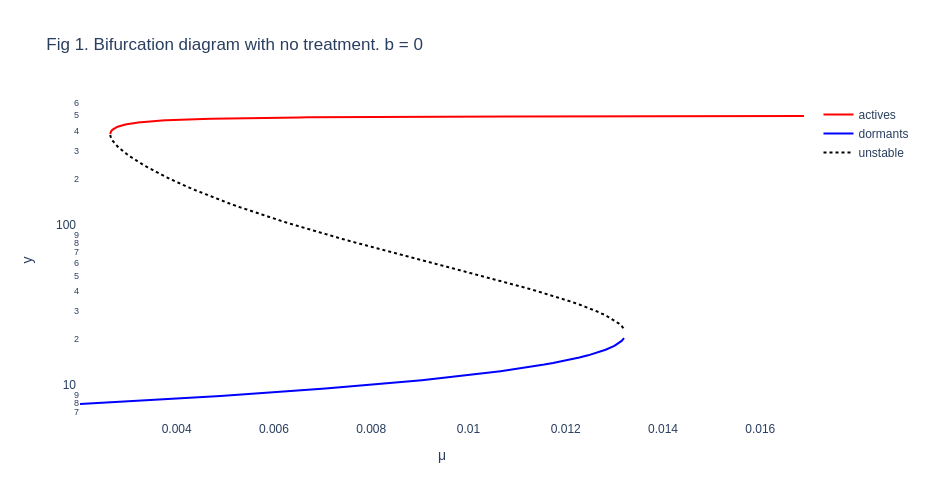

In [83]:
fig.add_trace(go.Scatter(x=actives.mu, y=actives.y, mode='lines', name = "actives",
                        line={"color":"red"}|get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=dormants.mu, y=dormants.y, mode='lines', name = "dormants",
                        line={"color":"blue"}|get_line_mode(stable=True)))

fig.add_trace(go.Scatter(x=unstables.mu, y=unstables.y, mode='lines', name = "unstable",
                        line={"color":"black"}|get_line_mode(stable=False)))
# fig.add_trace(go.Scatter(x=df.mu, y=df.y, mode='markers', name = "y"))
fig.update_layout(title="Fig 1. Bifurcation diagram with no treatment. b = 0")
fig.update_layout(xaxis={"title": "μ"}, yaxis={"title": "y"}, template="plotly_white",autosize=False,
    width=600,
    height=500)
fig.update_yaxes(type="log")
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)